Show that PMC model is working, looks like it is, next step is to combine a sine wave with noise, this will allow me to figure out how the SNR and normalisation can be fixed

In [1]:
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/classifiers/fhmm/development', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [6]:
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import numpy as np
import matplotlib.pyplot as plt
from spafe.features import mfcc
from importlib import reload
import hmmlearn.hmm as hmm
import utils
reload(utils)
from spafe.utils import vis
from matplotlib.pyplot import figure
figure(figsize=(4, 4), dpi=60)

<Figure size 240x240 with 0 Axes>

<Figure size 240x240 with 0 Axes>

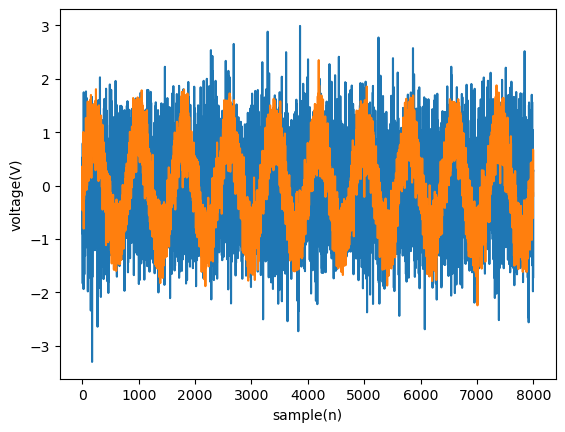

In [27]:
Fs = 8000
f1 = 20 # hz
f2 = 2000
sample = 8000
x = np.arange(sample)
n1 = np.random.normal(0, np.sqrt(0.1), sample)
n2 = np.random.normal(0, np.sqrt(0.58), sample)
s1 = np.sin(np.pi * f1 * x / Fs) + n1
s2 = n2
plt.plot(x, s2)
plt.plot(x, s1)
# plt.plot(x, noise)
plt.xlabel('sample(n)')
plt.ylabel('voltage(V)')
plt.show()

0.565967389580844


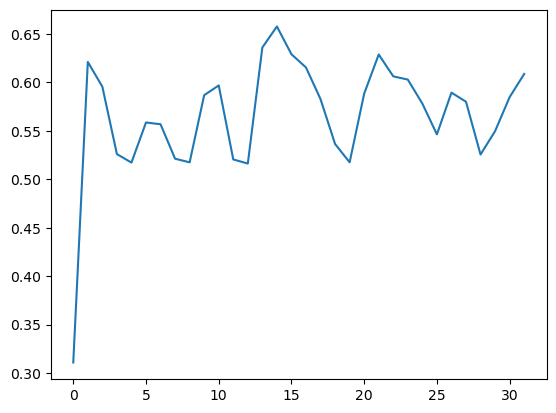

In [28]:
# snr before normalisation

ap = utils.periodic_power(s2, 500, 250)
plt.plot(ap)
print(np.mean(ap))
s1_ap = 0.5
s2_ap = 0.5
snr = s1_ap / s2_ap

In [29]:
# import librosa
# s1 = librosa.util.normalize(s1)
# s2 = librosa.util.normalize(s2)
# plt.plot(x, s2)
# plt.plot(x, s1)
# # plt.plot(x, noise)
# plt.xlabel('sample(n)')
# plt.ylabel('voltage(V)')
# plt.show()

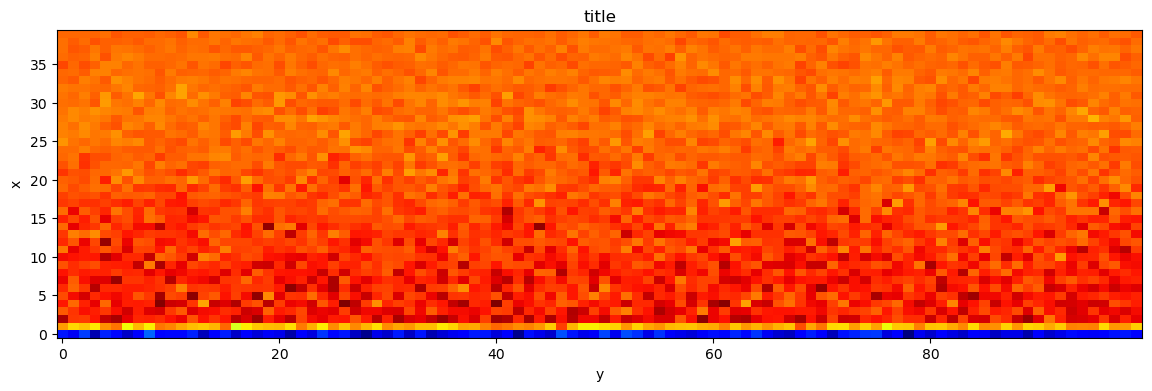

In [30]:

s1_feat = mfcc.mfcc(sig=s1, fs=8000, num_ceps=40, nfilts=40)
s1_hmm = hmm.GaussianHMM(1)
s1_hmm.fit(s1_feat)
s1_hmm_sampled, _ = s1_hmm.sample(100)
vis.show_features(s1_hmm_sampled, 'title', 'x', 'y')

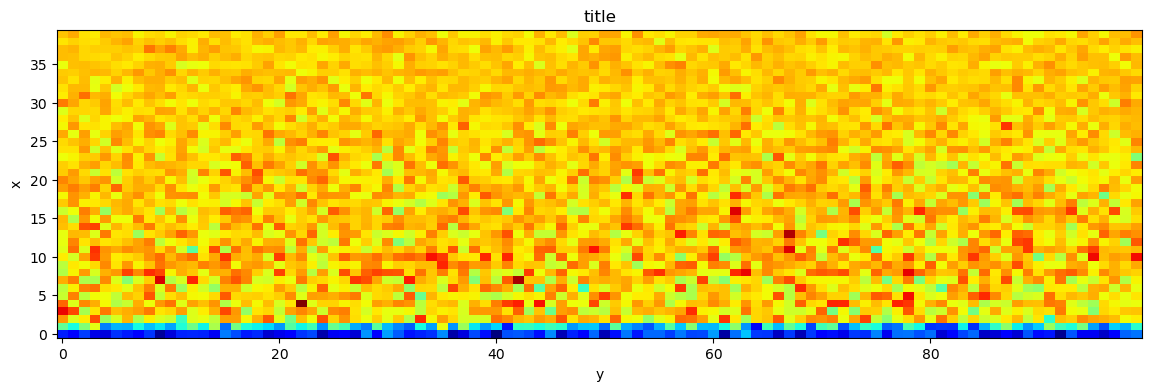

In [31]:
s2_feat = mfcc.mfcc(sig=s2, fs=8000, num_ceps=40, nfilts=40)
s2_hmm = hmm.GaussianHMM(1)
s2_hmm.fit(s2_feat)
s2_hmm_sampled, _ = s2_hmm.sample(100)
vis.show_features(s2_hmm_sampled, 'title', 'x', 'y')

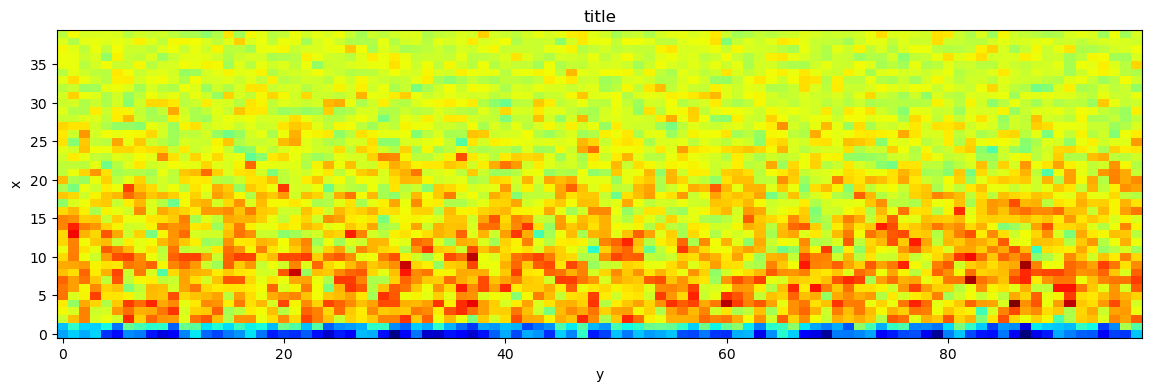

In [32]:
s3 = s1 + s2
s3_feat = mfcc.mfcc(sig=s3, fs=8000, num_ceps=40, nfilts=40)
vis.show_features(s3_feat[:100,:], 'title','x', 'y')

In [33]:
from processing import process_method_base
from classifiers.fhmm import classifier_fhmm
reload(classifier_fhmm)
import feature_extraction.fe_spafe.fe_spafe as fe_spafe

fe_method = fe_spafe.FeatureExtractorSpafe(fe_spafe.MFCC)
process_method = process_method_base.ProcessMethodBase(snr_db=40, reverb=False)
classifier = classifier_fhmm.ClassifierFHMM(fe_method, process_method)
classifier.hmms = {
    's1': s1_hmm
}
classifier.noise_hmm = s2_hmm
classifier.snr_noise = 1
classifier.adapt_speaker_models()

combined_hmm = classifier.hmms['s1']

# test on hmms
s3_hmm = hmm.GaussianHMM(1)
s3_hmm.fit(s3_feat)

GaussianHMM()

In [34]:
# vis.show_features(cept_features, 'title', 'x', 'y')
import classifiers.fhmm.helper_functions as hf
reload(hf)

def plot_params(params: hf.StatParams, gauss_hmm: hmm.GaussianHMM):
    x_axis = np.arange(len(params.mu.flatten()))
    params_var = np.diag(params.cov[0, :, :])
    hmm_var = np.diag(gauss_hmm.covars_[0, :, :])
    plt.stem(x_axis, params.mu.flatten() + params_var, linefmt='g')
    plt.stem(x_axis, params.mu.flatten() - params_var, linefmt='g')
    plt.plot(x_axis, params.mu.flatten(), c='g')
    plt.stem(x_axis, gauss_hmm.means_.flatten() + hmm_var, linefmt='b')
    plt.stem(x_axis, gauss_hmm.means_.flatten() - hmm_var, linefmt='b')
    plt.plot(x_axis, gauss_hmm.means_.flatten(), c='b')

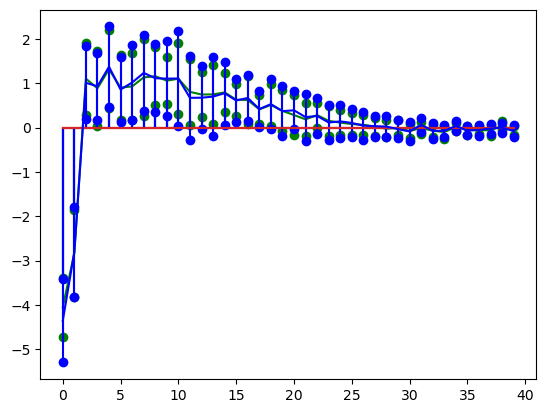

In [35]:
combined_params = hf.StatParams(combined_hmm.means_, combined_hmm.covars_)
plot_params(combined_params, s3_hmm)

In [27]:
combined_hmm.means_.flatten()

array([21.60880792,  3.67278547,  3.07785419,  2.89772885,  2.67065297,
        2.44458653,  2.12130003,  1.91581435,  1.64269032,  1.30981979,
        0.98763612,  0.71719141])

In [36]:
# likelihood of combined pmc model vs trained on real data model:
print(s3_hmm.score(s3_feat), combined_hmm.score(s3_feat), s1_hmm.score(s3_feat))

-3755.5687028495768 -3833.9345970750637 -11300.24497268525
